In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
from keras.models import load_model

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()



In [19]:
model = tf.saved_model.load('models/SA_Model_Final_2')


model.summary()
model.optimizer

model.get_weights()

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=50),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.load_weights('weights/SA_Model_Final_Weights.h5')

In [20]:
train = pd.read_csv("~/development/anjana/datasets/ECNG3020_Train_Dataset.csv")
test = pd.read_csv("~/development/anjana/datasets/ECNG3020_Test_Dataset.csv")

In [21]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    labels = labels.replace(["0","1","2","3","4","5"],['sadness','joy','love','anger','fear','surprise'])
    return tweets, labels

In [22]:
tweets, labels = get_tweet(train)

classes

labels ('sadness','joy','love','anger','fear','surprise')

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[1]])

[[168, 45, 2, 946, 10, 136, 2, 89, 38, 2, 83, 1213, 7, 1241, 1145, 80, 344]]

In [24]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [26]:
classes = ['fear', 'anger', 'surprise', 'sadness', 'love', 'joy']
print(classes)

['fear', 'anger', 'surprise', 'sadness', 'love', 'joy']


{'joy', 'love', 'sadness', 'anger', 'surprise', 'fear'}

In [27]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

msg = ["When, as a child, I was nearly knocked down by a car."] #fear
msg_seq = get_sequences(tokenizer, msg)

p = model.predict(msg_seq)[0]
#p = model.predict(np.expand_dims(msg_seq[0], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)


p

names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

_=model.evaluate(test_seq, test_labels)

In [28]:
list(model.signatures.keys())

['serving_default']

In [29]:
infer = model.signatures["serving_default"]
print(infer.structured_outputs)

{'dense': TensorSpec(shape=(None, 6), dtype=tf.float32, name='dense')}


In [30]:
msg = ["Finding out that I was deceived by a friend."]
msg_seq = get_sequences(tokenizer, msg)


labeling = infer(tf.constant(msg_seq, dtype=tf.float32))["dense"] #dense specifies the output layer

#decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

#p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(labeling).astype('uint8')]

labeling
pred_class

'anger'

In [31]:
test_tweets, test_labels = get_tweet(test)
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
test_labels = names_to_ids(test_labels)

pred = []

for message in test_tweets:
    msg_seq = get_sequences(tokenizer, [message])
    labeling = infer(tf.constant(msg_seq, dtype=tf.float32))["dense"]
    pred.append(np.argmax(labeling).astype('uint8'))

In [32]:
list(classes)

['fear', 'anger', 'surprise', 'sadness', 'love', 'joy']

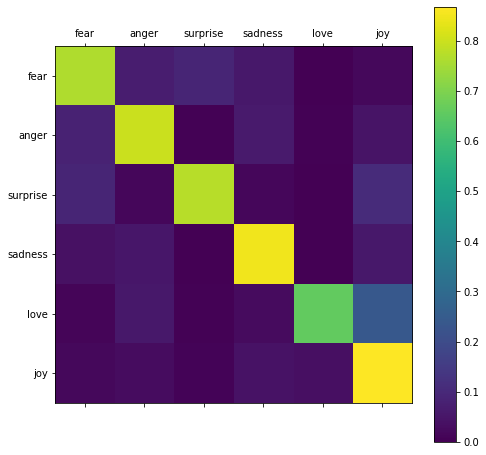

In [33]:
show_confusion_matrix(test_labels, pred, list(classes))